**Importing Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pickle 
import imageio

**Data Preparation**

In [2]:
data_path = "expert_data/human_demos_4_-111.0.pkl"

with open(data_path, 'rb') as f:
    trajs = pickle.load(f)

print(f"Number of trajectories: {len(trajs)}") 

Number of trajectories: 4


**Data Preparation**

In [3]:
states=[]
actions=[]
for traj in trajs:
    for state,action in traj:
        states.append(state)
        actions.append(action)

states=np.array(states)
actions=np.array(actions)

states.shape,actions.shape

((438, 2), (438,))

In [4]:
num_classes = np.max(actions)+1 
num_classes

3

In [5]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 2]), torch.Size([64]))

**Neural Net**

In [6]:
class BcNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BcNet, self).__init__()
        self.layer1 = nn.Linear(state_dim, 64)
        self.layer2 = nn.Linear(64, 32) 
        self.layer3 = nn.Linear(32, action_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x)) 
        x = self.layer3(x)
        # x = F.softmax(x, dim=1)
        return x

**Training Setup**

In [7]:
bc= BcNet(2, 3)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc.parameters(), lr = learning_rate)

In [8]:
loss_list = []  
n_epoch = 250
 
for itr in range(0, n_epoch+1):
    for batch_states, batch_actions in data_loader:
        y_pred = bc(batch_states)
        loss = criterion(y_pred, batch_actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    if itr % 10 == 0:
        print(f'iteration: {itr}, loss: {loss.item()}')

iteration: 0, loss: 0.6967720985412598
iteration: 10, loss: 0.5248939394950867
iteration: 20, loss: 0.17399059236049652
iteration: 30, loss: 0.06051889434456825
iteration: 40, loss: 0.01703745871782303
iteration: 50, loss: 0.13335222005844116
iteration: 60, loss: 0.059711817651987076
iteration: 70, loss: 0.038253799080848694
iteration: 80, loss: 0.006528567988425493
iteration: 90, loss: 0.07751794904470444
iteration: 100, loss: 0.13059966266155243
iteration: 110, loss: 0.02206268347799778
iteration: 120, loss: 0.11455276608467102
iteration: 130, loss: 0.0864592045545578
iteration: 140, loss: 0.24288101494312286
iteration: 150, loss: 0.07264873385429382
iteration: 160, loss: 0.09686286002397537
iteration: 170, loss: 0.034400034695863724
iteration: 180, loss: 0.00991920754313469
iteration: 190, loss: 0.12293247878551483
iteration: 200, loss: 0.040878910571336746
iteration: 210, loss: 0.08412448316812515
iteration: 220, loss: 0.12110256403684616
iteration: 230, loss: 0.07574222981929779
i

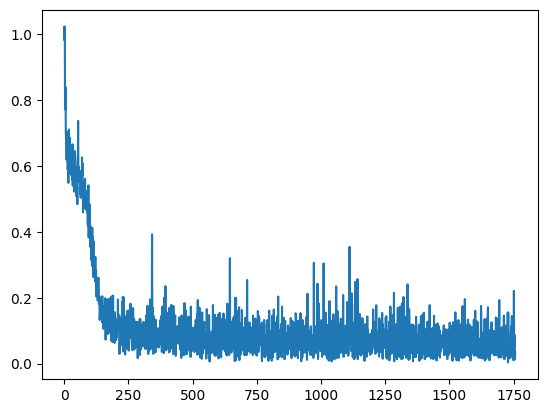

In [9]:
plt.plot(loss_list)

**Accuracy**

In [10]:
bc.eval()
train_x=torch.tensor(states).float()
train_y=torch.tensor(actions).long()
with torch.no_grad():
    y_pred = bc(train_x)
    correct = (torch.argmax(y_pred, dim=1) == train_y ).type(torch.FloatTensor)
    print('training accuracy: ', correct.mean())

training accuracy:  tensor(0.9844)


**Testing**

In [11]:
env_name='MountainCar-v0'

In [15]:
def run(env_name, model, video_path=None, max_steps=1000):
    env=gym.make(env_name, render_mode='human')

    obs,_=env.reset()
    rewards=0
    step=0
    for _ in range(max_steps):
        step+=1
        obs=torch.tensor(obs).float()
        predict=model(obs)
        action=torch.argmax(predict).item() 
        obs, reward, done, trunc,_ = env.step(action)

        if video_path is not None:
            image=env.render()

        rewards+=reward
        if done or trunc:
            break

    return {'reward':rewards, 'step':step-1}

In [17]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    stats=run(env_name, bc)
    rewards=stats['reward']
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: -112.00
episode #1 reward: -112.00
episode #2 reward: -115.00
episode #3 reward: -112.00
episode #4 reward: -112.00
episode #5 reward: -111.00
episode #6 reward: -112.00
episode #7 reward: -112.00
episode #8 reward: -111.00
episode #9 reward: -112.00
episode #10 reward: -112.00
episode #11 reward: -117.00
episode #12 reward: -121.00
episode #13 reward: -114.00
episode #14 reward: -110.00
episode #15 reward: -111.00
episode #16 reward: -113.00
episode #17 reward: -112.00
episode #18 reward: -112.00
episode #19 reward: -112.00

 score: -112.75 +- 2.41
